In [1]:
import numpy as np
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [2]:
# 1. Load data
cov = fetch_covtype(download_if_missing=True)
X, y = cov.data, cov.target

In [3]:
# 2. Filter out classes 1 and 2
mask = ~np.isin(y, [1, 2])
X_filt = X[mask]
y_filt = y[mask]

print("After filtering:", np.bincount(y_filt).astype(int))

After filtering: [    0     0     0 35754  2747  9493 17367 20510]


In [4]:
# 3. Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_filt, y_filt,
    test_size=0.2,
    stratify=y_filt,
    random_state=42
)

In [5]:
# 3. Pipeline: scaling + logistic regression
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        multi_class='multinomial',
        solver='saga',
        max_iter=200,
        n_jobs=-1,
        random_state=42
    ))
])

In [10]:
# 4. Hyper‐parameter grid
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2'],
    # note: saga solver supports both l1 and l2
}

In [7]:
# 5. Grid search with 5-fold CV
grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='f1_weighted',  # optimize for weighted F1
    n_jobs=-1,
    verbose=2
)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print(f"Best CV weighted F1: {grid.best_score_:.4f}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters: {'logreg__C': 1, 'logreg__penalty': 'l1'}
Best CV weighted F1: 0.7779


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [8]:
# 6. Evaluate on test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nTest set performance:")
print(f"  Accuracy : {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall   : {rec:.4f}")
print(f"  F1-score : {f1:.4f}")

# (Optional) Full classification report
print("\nDetailed classification report:")
print(classification_report(y_test, y_pred, digits=4))


Test set performance:
  Accuracy : 0.8018
  Precision: 0.7973
  Recall   : 0.8018
  F1-score : 0.7901

Detailed classification report:
              precision    recall  f1-score   support

           3     0.7298    0.8888    0.8015      7151
           4     0.6188    0.4080    0.4918       549
           5     0.9070    0.8578    0.8817      1899
           6     0.6680    0.4263    0.5205      3474
           7     0.9976    0.9949    0.9962      4102

    accuracy                         0.8018     17175
   macro avg     0.7842    0.7152    0.7383     17175
weighted avg     0.7973    0.8018    0.7901     17175



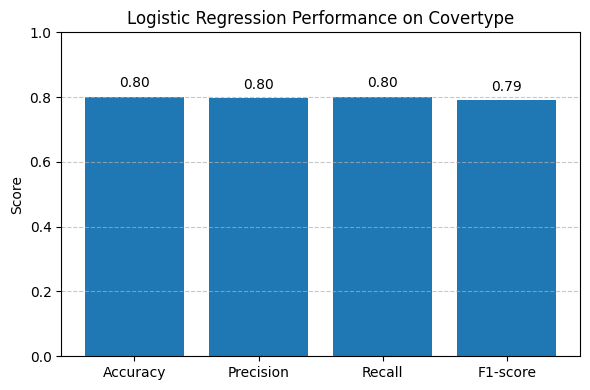

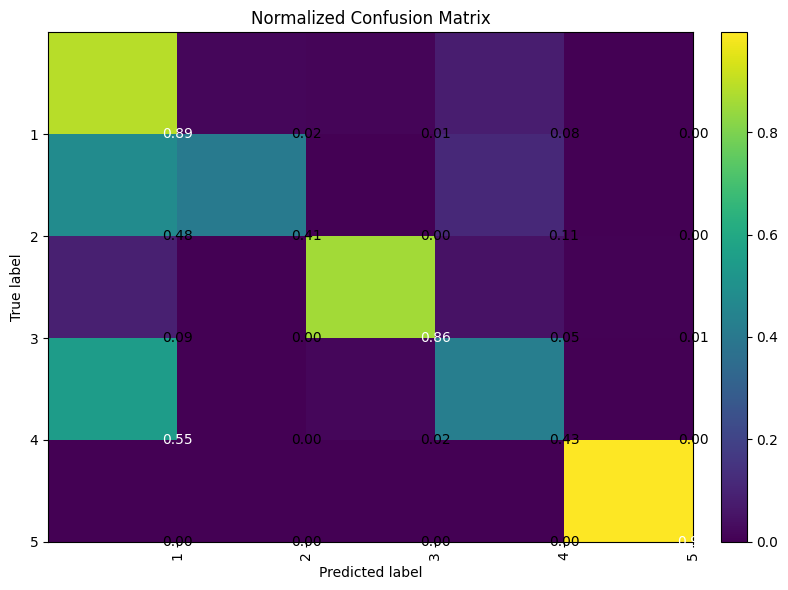

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# — after you’ve computed acc, prec, rec, f1 and y_test, y_pred —

# 1) Bar chart of overall metrics
metrics = {
    'Accuracy': acc,
    'Precision': prec,
    'Recall':    rec,
    'F1-score':  f1
}

plt.figure(figsize=(6,4))
keys = list(metrics.keys())
values = [metrics[k] for k in keys]
bars = plt.bar(keys, values)
plt.ylim(0,1)
plt.ylabel('Score')
plt.title('Logistic Regression Performance on Covertype')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# annotate bars
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.02, f'{h:.2f}',
             ha='center', va='bottom')
plt.tight_layout()
plt.show()


# 2) Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalized by true class

plt.figure(figsize=(8,6))
im = plt.imshow(cm_norm, interpolation='nearest', aspect='auto')
plt.title('Normalized Confusion Matrix')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xlabel('Predicted label')
plt.ylabel('True label')
tick_marks = np.arange(cm.shape[0])
plt.xticks(tick_marks + 0.5, tick_marks + 1, rotation=90)  # classes are 1…7
plt.yticks(tick_marks + 0.5, tick_marks + 1)

# annotate each cell
thresh = cm_norm.max() / 2.
for i, j in np.ndindex(cm_norm.shape):
    plt.text(j + 0.5, i + 0.5, f"{cm_norm[i, j]:.2f}",
             ha="center", va="center",
             color="white" if cm_norm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()